# Question  1a

In [1]:
import pyshark
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()

In [2]:
def classify(pkt , ip):   # Classifies if a packet is uplink / downlink or neither
    if 'IP' in pkt:
        src_ip = pkt.ip.src
        dst_ip = pkt.ip.dst
        if src_ip == ip:
            return 'uplink'
        if dst_ip == ip:
            return 'downlink'
    else:
        return None

def plot(pcap , our_ip , granularity , burst_threshold , filename):
    start_time = float(pcap[0].sniff_timestamp) 
    time_points = []
    uplink_counts = []                           # keeps track of uplink packets in each slot
    downlink_counts = []
    uplink_byte = []
    downlink_byte = []
    # keeps track of downlink packets in each slot
    uplink = 0
    downlink = 0
    uplink_bytes = 0
    downlink_bytes = 0
    curr_slot = 1                                # running counter for the current slot of time
    
    for pkt in pcap:
        sniff_timestamp = float(pkt.sniff_timestamp)
        if sniff_timestamp - start_time >= curr_slot * granularity:
            uplink_counts.append(uplink)
            downlink_counts.append(downlink)
            uplink_byte.append(uplink_bytes)
            downlink_byte.append(downlink_bytes)
            time_points.append(curr_slot * granularity)
            curr_slot+=1
            uplink = 0
            downlink = 0
            uplink_bytes = 0
            downlink_bytes = 0
        if classify(pkt , our_ip) == 'uplink':
            uplink+=1
            uplink_bytes+=float(pkt.length)
        if classify(pkt , our_ip) == 'downlink':
            downlink+=1
            downlink_bytes+=float(pkt.length)
    
    burst_slots = 0
    for i in downlink_counts:                   # finding the number of burst slots 
        if i > burst_threshold:
            burst_slots+=1
    
    for i in range(len(uplink_counts)):
        uplink_counts[i]/=granularity
    
    for i in range(len(downlink_counts)):
        downlink_counts[i]/=granularity

    for i in range(len(uplink_byte)):
        uplink_byte[i]/=granularity
        uplink_byte[i]/=1000

    for i in range(len(downlink_byte)):
        downlink_byte[i]/=granularity
        downlink_byte[i]/=1000
    
    plt.plot(time_points , uplink_counts , color = 'red')
    plt.xlabel("Time")
    plt.ylabel("Uplink traffic (Packets per sec)")
    plt.title("Uplink traffic for - " + filename)
    plt.show()
    plt.plot(time_points , downlink_counts , color = 'blue')
    plt.xlabel("Time")
    plt.ylabel("Downlink traffic (Packets per sec)")
    plt.title("Downlink traffic for - " + filename)
    plt.show()
    plt.xlabel("Time")
    plt.ylabel("Uplink traffic (KB/s)")
    plt.title("Uplink traffic for - " + filename)
    plt.plot(time_points , uplink_byte , color = "red")
    plt.show()
    plt.xlabel("Time")
    plt.ylabel("Downlink traffic (KB/s)")
    plt.title("Downlink traffic for - " + filename)
    plt.plot(time_points , downlink_byte , color = "blue")
    plt.show()
    
    print("Fraction of downlink burst slots - " , burst_slots/curr_slot)
    

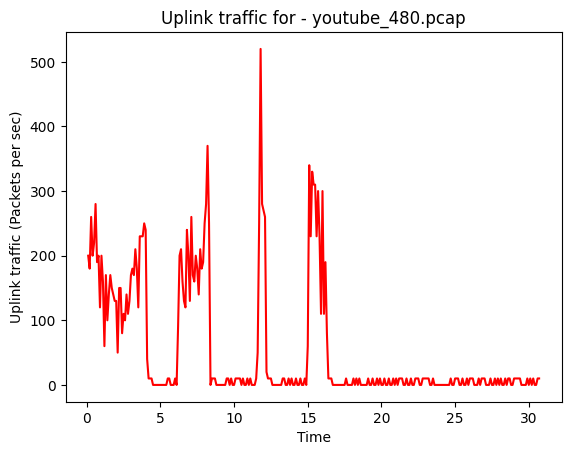

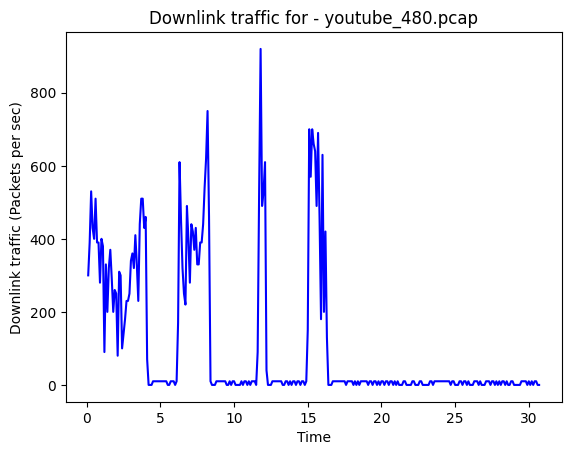

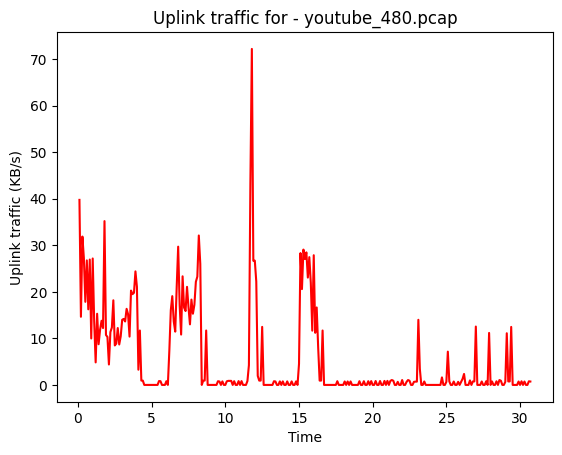

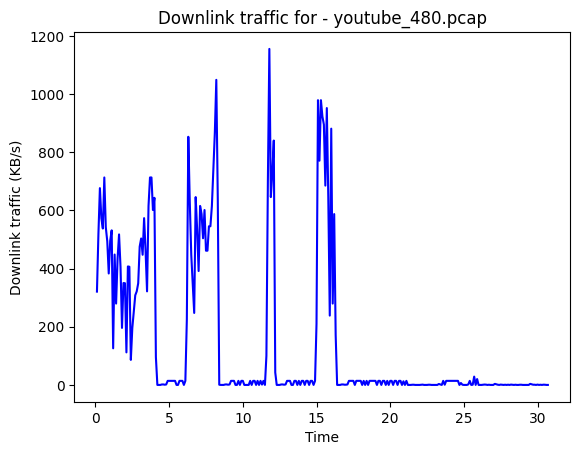

Fraction of downlink burst slots -  0.0


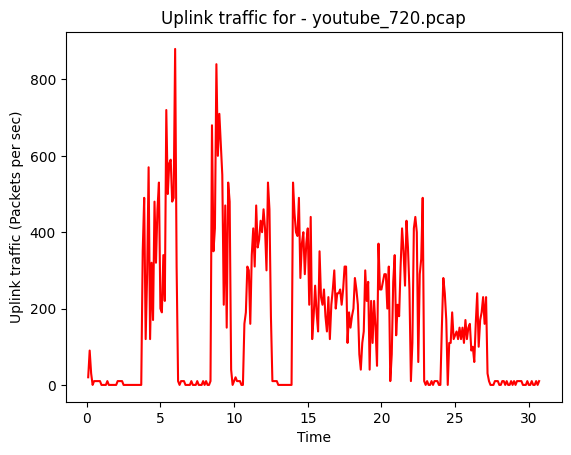

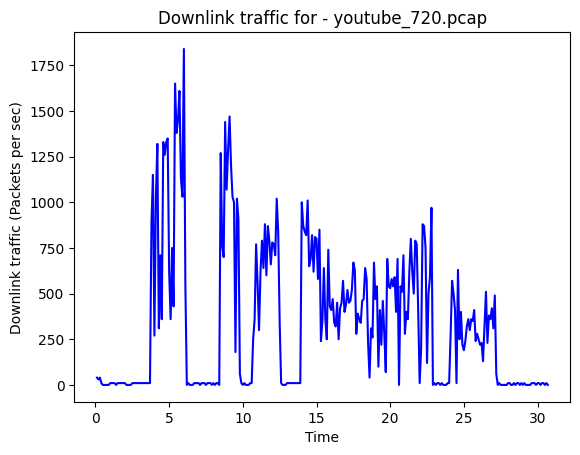

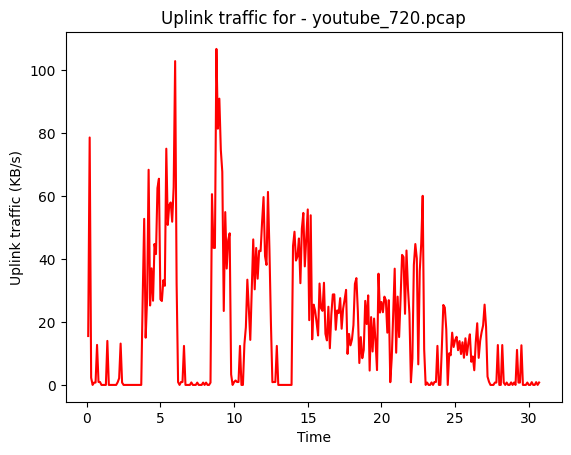

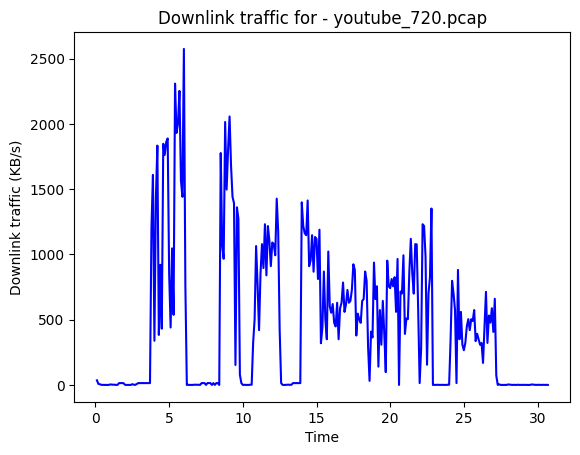

Fraction of downlink burst slots -  0.07792207792207792


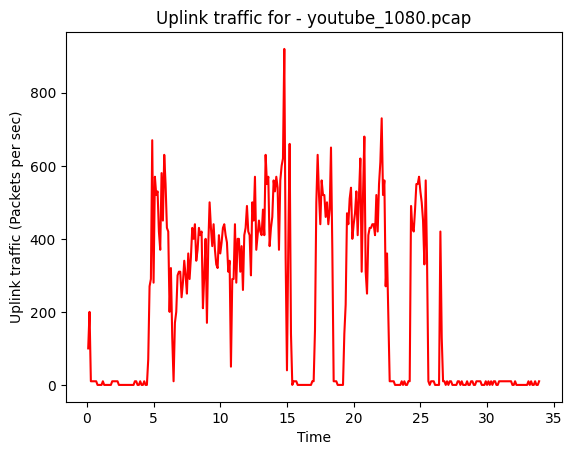

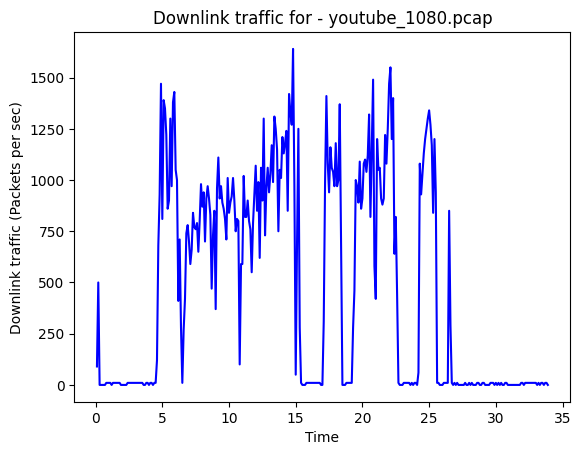

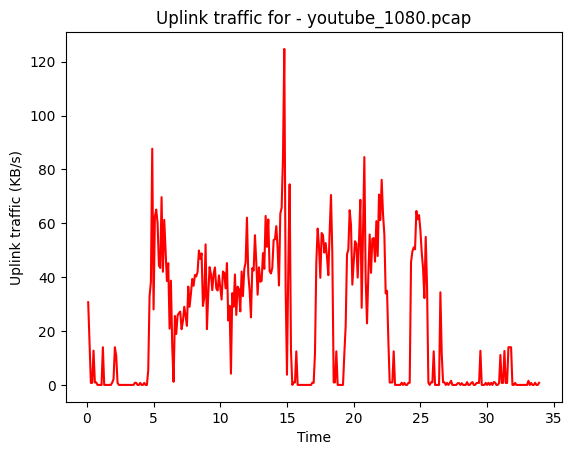

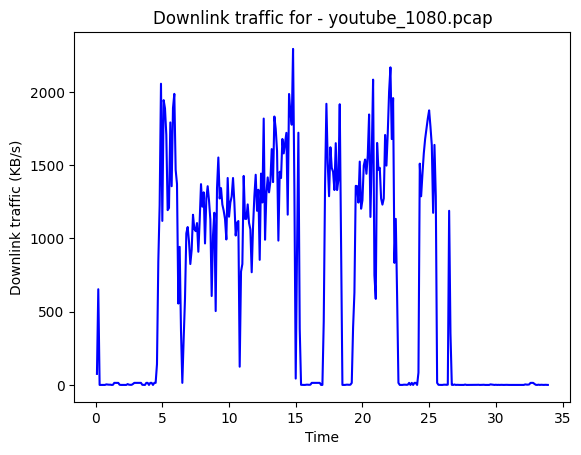

Fraction of downlink burst slots -  0.19705882352941176


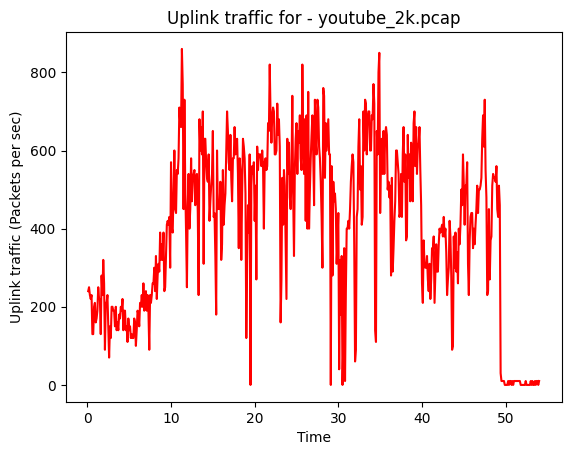

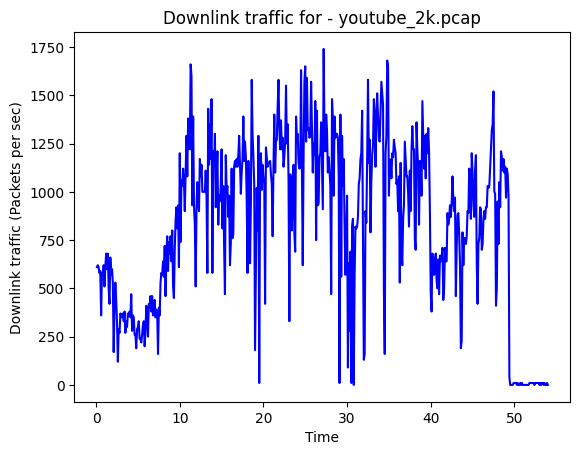

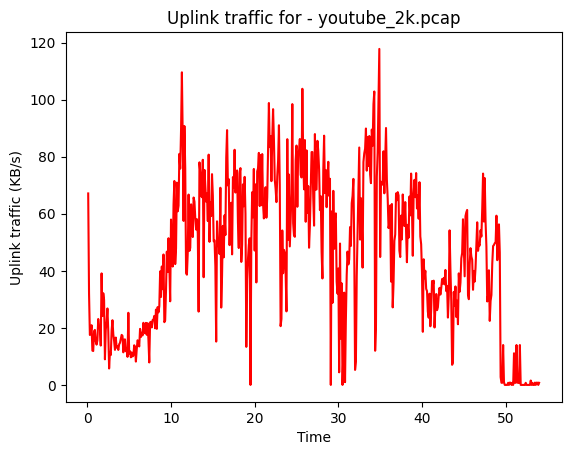

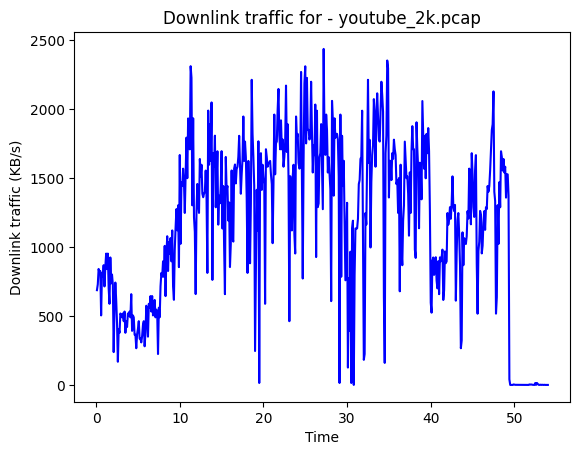

Fraction of downlink burst slots -  0.42513863216266173


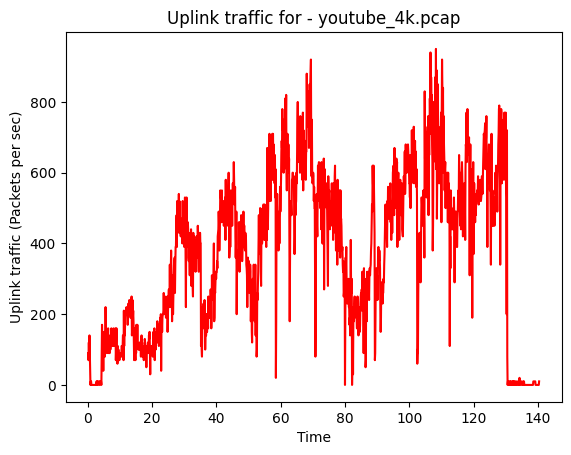

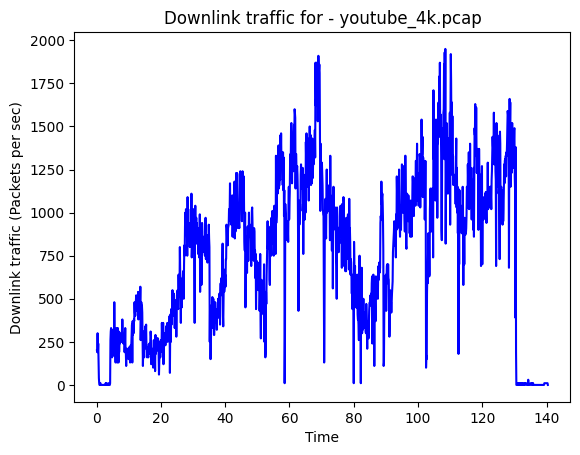

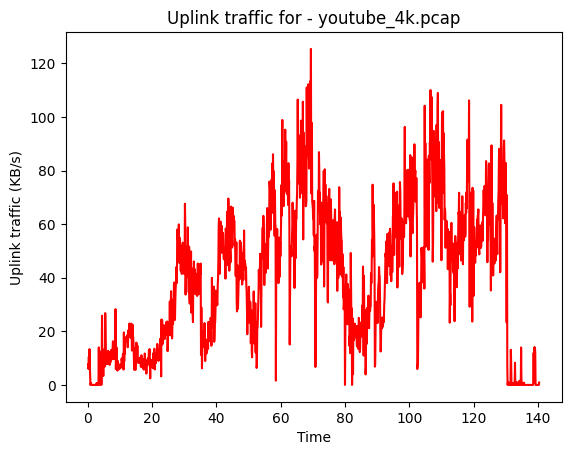

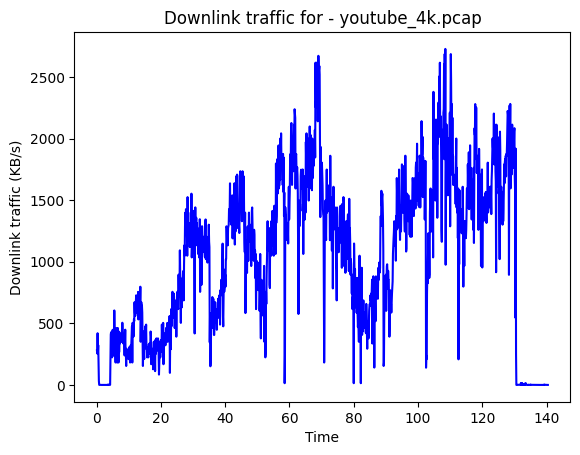

Fraction of downlink burst slots -  0.3409252669039146


In [3]:
files = ["youtube_480.pcap" , "youtube_720.pcap" , "youtube_1080.pcap" , "youtube_2k.pcap" , "youtube_4k.pcap"]
# files = ["youtube_480.pcap" , "youtube_720.pcap" , "youtube_1080.pcap" , "youtube_2k.pcap"]

for file in files:
    pcap = pyshark.FileCapture(file)            # pcap files in the same folder as the notebook and following the naming format  
    our_ip = "192.168.19.125"                    # Enter the IP of the user  
    plot(pcap , our_ip , 0.1 , 100 , file)
    

# Question 1b

In [4]:
def get_DNSCompletion(pcap , domain , file):  
    first_qry = 0
    last_qry = 0
    id = None
    for pkt in pcap:
        if 'DNS' in pkt:
            try:
                if pkt['DNS'].qry_name == domain:
                    first_qry = float(pkt.sniff_timestamp)
                    id = pkt['DNS'].id
                    break
            except:
                pass
    
    for pkt in pcap:
        if 'DNS' in pkt:
            try:
                if pkt['DNS'].id == id:
                    last_qry = float(pkt.sniff_timestamp)
            except:
                pass
    
    print("The total time taken for DNS query to compelete for file " + file + " is - ", 1000*(last_qry - first_qry) , " ms")       
    

In [5]:
def get_TTFB(pcap , domain , file):
    
    first_qry_time = 0
    server_hello = 0
    first_data_time = 0
    
    for pkt in pcap:
        if 'DNS' in pkt:
            try:                                                        # checking for the first DNS packet corresponding to our domain name 
                if pkt['DNS'].qry_name == domain:
                    first_qry_time = float(pkt.sniff_timestamp) 
                    break
            except:
                pass
    for pkt in pcap:
        if 'TLS' in pkt:
            try:                                                        # checking if server hello has been completed
                if pkt['TLS'].handshake_type == str(2):
                    server_hello = 1
            except:
                pass
            try:
                if pkt['TLS'].record_opaque_type == str(23):            # checking if it's and application packet 
                    if server_hello == 1:                    
                        first_data_time = float(pkt.sniff_timestamp)
                        break
            except:
                pass
    print("The TTFB is for file " + file +  " is - " , (first_data_time - first_qry_time) * 1000 , " ms")
            

In [6]:
def plot_cum(pcap , our_ip , file , domain):
    start_time = float(pcap[0].sniff_timestamp)
    time_points = []
    downlink_data = []
    curr_slot = 1
    downlink = 0
    for pkt in pcap:
        sniff_timestamp = float(pkt.sniff_timestamp)
        if sniff_timestamp - start_time >= curr_slot * 0.1:
            downlink_data.append(downlink)
            time_points.append(curr_slot * 0.1)
            curr_slot+=1
            downlink = 0
        if 'TLS' in pkt: 
            if classify(pkt , our_ip) == 'downlink':                # checking if the packet is an application packet and downlinked 
                try:
                    if pkt['TLS'].record_opaque_type==str(23):
                        downlink+=float(pkt['TLS'].record_length)
                except:
                    pass
    for i in range(len(downlink_data) - 1):
        downlink_data[i+1]+=downlink_data[i]
    for i in range(len(downlink_data)):
        downlink_data[i]/=downlink_data[-1]
        downlink_data[i]*=100
    plt.plot(time_points , downlink_data , color = "red")
    plt.xlabel("Time (s)")
    plt.ylabel("Cumulative percentage (%)")
    plt.title("Cumulative data transfer graph for " + file)
    plt.show()

The total time taken for DNS query to compelete for file deccan.pcap is -  453.4900188446045  ms
The TTFB is for file deccan.pcap is -  3869.655132293701  ms


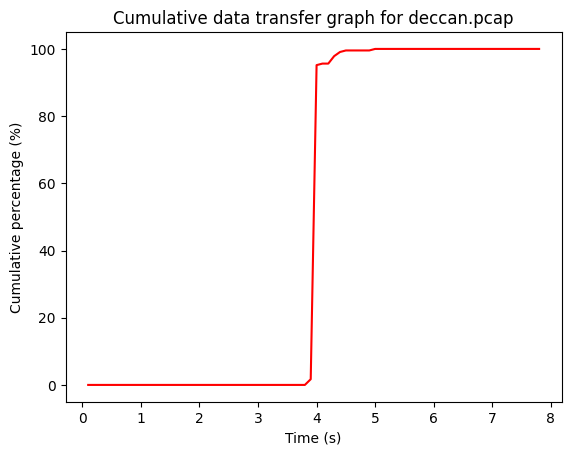

The total time taken for DNS query to compelete for file jagran.pcap is -  38.3758544921875  ms
The TTFB is for file jagran.pcap is -  75.30879974365234  ms


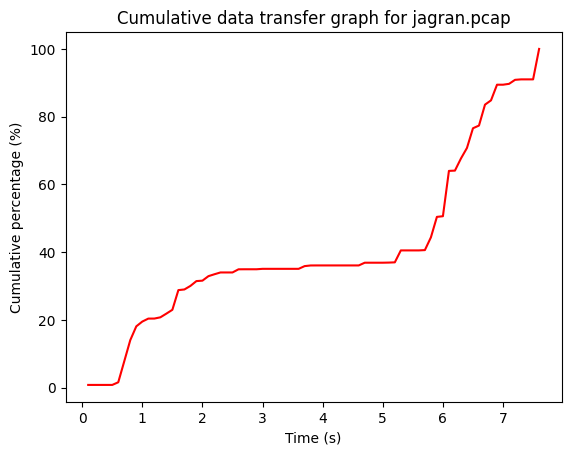

The total time taken for DNS query to compelete for file mit.pcap is -  42.92106628417969  ms
The TTFB is for file mit.pcap is -  1263.0438804626465  ms


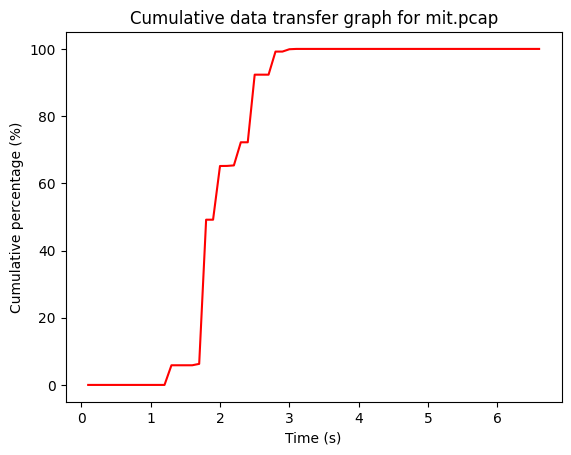

The total time taken for DNS query to compelete for file sinu.pcap is -  444.41890716552734  ms
The TTFB is for file sinu.pcap is -  1186.1300468444824  ms


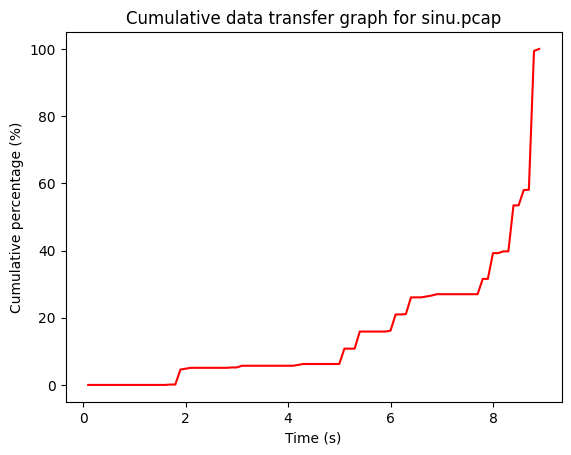

The total time taken for DNS query to compelete for file usach.pcap is -  39.51597213745117  ms
The TTFB is for file usach.pcap is -  3557.8010082244873  ms


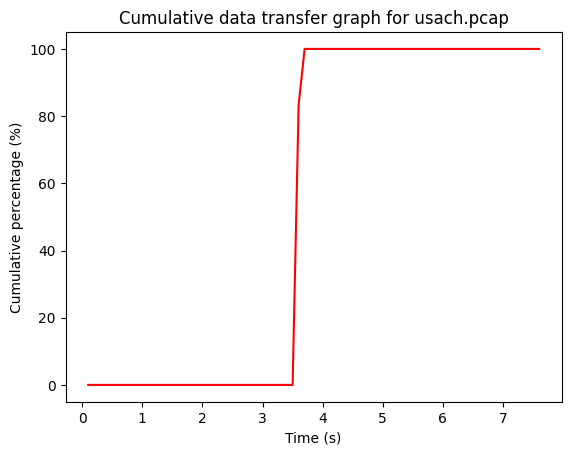

In [7]:
domain_list = ['deccan.com' , 'jagran.com' , 'mit.edu' , 'sinu.edu.sb' ,'usach.cl']
# list containing the domain names 
files = ['deccan.pcap' , 'jagran.pcap' , 'mit.pcap' , 'sinu.pcap' , 'usach.pcap']
# list of pcap files stored in the same folder as this notebook
my_ip = "192.168.19.125"

for i in range(len(files)) :
    pcap = pyshark.FileCapture(files[i])
    get_DNSCompletion(pcap , domain_list[i] , files[i])
    get_TTFB(pcap , domain_list[i] , files[i])
    plot_cum(pcap , my_ip , files[i] , domain_list[i])
    

# Insights into DNS resolution times

1. The MIT and jagran sites do DNS resolution pretty fast of the order of 50 ms due to a hit in a closer server.
2. We notice that DNS resolution time for deccan is pretty high to the contrary which I think can be accounted for due to a bad internet connection
3. Sinu and usach take a lot of time being foreign and not usually accessed websites take a significant amount of time to DNS resolve.
4. MIT even though being a foreign website may have it's domain to ip cached in a server here at India. 